# Phase Transitions of Full Model

This notebook compute the finite-temperature effective potential and the phase transition of the full model.

In [53]:
from cosmoTransitions import generic_potential as gp
import numpy as np
import scipy as sp
import scipy.optimize as op
from cosmoTransitions import pathDeformation as pd
from scipy import interpolate
from cosmoTransitions import helper_functions
from matplotlib import pyplot as plt

## Pre-definitions

The parameters are renormalized under $\overline{\rm MS}$ scheme at 1-loop level with renormalization scale $\mu=m_Z$.

In [54]:
GF = 1.16637e-05
v = 1/(np.sqrt(2*np.sqrt(2)*GF))
mHSM = 125.13
g1=0.357457
g2=0.651009
yt=0.981588
mW=80.379
mZ=91.1876

## Define the model

In [93]:
class full_model(gp.generic_potential):
    """
    The full scalar model for phase transition research.
    
    This class defines the thermal effective potential, as long as every functions
    we need to compute the related physical quantities.
    """
    def init(self,muHsq,muSsq,lh,A,f,delta):
        """
        Initialize the parameters. The parameters should be understood as
        the 1-loop MSbar renormalized parameters. The renormalization are computed
        in Mathematica and are imported here.
        """
        self.Ndim=2
        self.Tmax=200
        self.muHsq=muHsq
        self.muSsq=muSsq
        self.lh=lh
        self.A=A
        self.f=f
        self.delta=delta
        self.renormScaleSq = mZ**2
        self.l1 = .5*100**2/(2*v**2)
        self.l2 = .5*50**2/(2*v**2)
        self.mu2 = 100**2
        
    def approxZeroTMin(self):
        return [np.array([v*2**0.5, 0])]
    
    def V0(self, X):
        """
        This method defines the tree-level potential. It should generally be
        subclassed. (You could also subclass Vtot() directly, and put in all of
        quantum corrections yourself).
        """
        # X is the input field array. It is helpful to ensure that it is a
        # numpy array before splitting it into its components.
        X = np.asanyarray(X)
        # x and y are the two fields that make up the input. The array should
        # always be defined such that the very last axis contains the different
        # fields, hence the ellipses.
        # (For example, X can be an array of N two dimensional points and have
        # shape (N,2), but it should NOT be a series of two arrays of length N
        # and have shape (2,N).)
        h, S = X[...,0], X[...,1]
        Vtree = - 0.5 * self.muHsq * h**2 + 0.25 * self.lh * h**4
        Vtree += self.muSsq * self.f**2 *(1-np.cos(S/self.f))
        Vtree += - 0.5 * self.A * self.f * (h**2 - 2*v**2) * np.sin(S/self.f + self.delta)
        return Vtree


    def boson_massSq(self,X,T):
        X=np.array(X)
        phi1 = X[...,0]
        mWsq = 0.25 * g2**2 * phi1**2
        mZsq = 0.25 * (g2**2 + g1**2) * phi1**2
        M = np.array([mWsq,mZsq])
        M = np.rollaxis(M,0,len(M.shape))
        
        dof = np.array([6,3])
        c = np.array([1.5,1.5])
        return M, dof, c
    
    def fermion_massSq(self,X):
        X = np.array(X)
        phi1 = X[...,0]
        mtsq = 0.5*yt**2 * phi1**2
        M = np.array([mtsq])
        M = np.rollaxis(M,0,len(M.shape))
        dof=np.array([12])
        return M, dof
    
    def tunneling_at_T(self,T):
        def V_(x, T=T, V=self.Vtot):
            return V(x,T)
        def dV_(x, T=T, dV=self.gradV):
            return dV(x,T)
        tobj = pd.fullTunneling([self.findMinimum(T).tolist(),self.findMinimum(1e-5).tolist()],V_,dV_)
        return tobj


In [2]:
import pandas as pd

In [15]:
MSbar_param=pd.read_csv("../model_setup/output/f_5_beta_pi10.csv")

In [17]:
MSbar_param.keys()

Index(['mS', 'sin', 'lh', 'A', 'muHsq', 'muSsq'], dtype='object')

In [94]:
benchmark_dataset=MSbar_param.loc[(MSbar_param["mS"]==5)&(MSbar_param["sin"]==0.16)]
testmuHsq=benchmark_dataset['muHsq'].iloc[0]
testmuSsq=benchmark_dataset['muSsq'].iloc[0]
testlh=benchmark_dataset['lh'].iloc[0]
testA=benchmark_dataset['A'].iloc[0]
model=full_model(testmuHsq,testmuSsq,testlh,testA,1e05,np.pi/10)

In [58]:
model.findAllTransitions()

Tracing phase starting at x = [256.05800945  58.25346116] ; t = 0.0
Tracing minimum up
traceMinimum t0 = 0
.............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[]

In [60]:
model.TcTrans

[{'Tcrit': 67.50320656573835,
  'high_vev': array([ 1.28382684e-03, -7.16523550e+02]),
  'high_phase': 1,
  'low_vev': array([  62.26331015, -670.60624708]),
  'low_phase': 0,
  'trantype': 1,
  'Delta_rho': 5521266.478464127}]

In [96]:
model.findMinimum(X=[80,-600],T=67.3).tolist()

[72.78958553782614, -653.7710401331422]

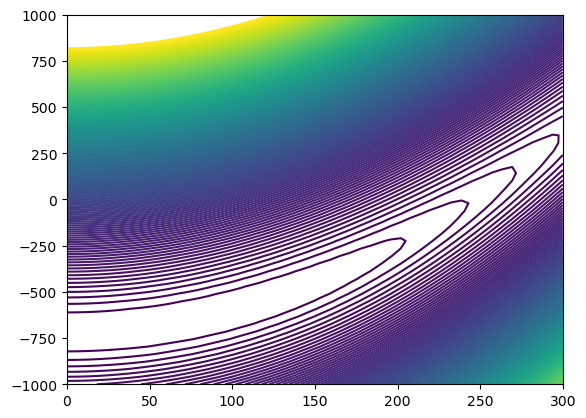

In [75]:
model.plot2d(box=[0,300,-1000,1000],T=66.9)

In [95]:
model.tunneling_at_T(T=67)

IndexError: index 1 is out of bounds for axis 0 with size 1